# Multi-Armed Bandits

## Agents

### Base

In [ ]:

import numpy as np
from collections import OrderedDict

In [ ]:

class Agent(object):
    def __init__(self, name):
        self.name = name
        self.history = OrderedDict()

    def init(self):
        pass

    def step(self, t):
        action = self._step(t)
        self.history[t] = (action, np.nan)
        return action

    def _step(self, t):
        raise NotImplementedError

    def get_reward(self, reward, t):
        assert t in self.history, "time t when the action was taken doesn't exist in history"
        action = self.history[t][0]
        self.history[t] = (action, reward)
        self._get_reward(action, reward, t)

    def _get_reward(self, action, reward, t):
        raise NotImplementedError

    def reset(self):
        self.history = OrderedDict()
        self.init()

### Epsilon Greedy

In [ ]:

import numpy as np

In [ ]:

class EpsilonGreedy(Agent):
    def __init__(self, n_actions, epsilon=None):
        name = r"$\epsilon$-greedy with $\epsilon$={}".format(epsilon) if epsilon is not None else r"Optimal $\epsilon$-greedy algorithm"
        super(EpsilonGreedy, self).__init__(name)
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.count_actions = None
        self.exp_reward = None
        self.init()

    def init(self):
        self.count_actions = np.zeros(self.n_actions)
        self.exp_reward = np.zeros(self.n_actions)

    def _step(self, t):
        if self.epsilon is None:
            epsilon = (t + 1) ** (-1/3) * (self.n_actions * np.log(t + 1)) ** (1/3)
        else:
            epsilon = self.epsilon
        valid_actions = np.arange(self.n_actions)
        if np.random.random() > epsilon:
            r = self.exp_reward
            valid_actions = valid_actions[r == r.max()]
        action = np.random.choice(valid_actions)
        self.count_actions[action] += 1
        return action

    def _get_reward(self, action, reward, t):
        self.exp_reward[action] += (reward - self.exp_reward[action]) / self.count_actions[action]

### Explore-Exploit

In [ ]:

import numpy as np

In [ ]:

class ExploreExploit(Agent):
    def __init__(self, n_actions, n_explore):
        super(ExploreExploit, self).__init__("Explore and exploit algorithm $N={}$".format(n_explore))
        self.n_explore = n_explore
        self.n_actions = n_actions
        self.count_actions = None
        self.sum_reward = None
        self.chosen_action = None
        self.init()

    def init(self):
        self.count_actions = np.zeros(self.n_actions, dtype=np.int)
        self.sum_reward = np.zeros(self.n_actions)

    def _step(self, t):
        count = self.count_actions.sum()
        if self.count_actions.min() < self.n_explore:
            action = self.count_actions.argmin()
        elif count == self.n_explore * self.n_actions:
            action = np.random.choice(np.arange(self.n_actions)[self.sum_reward == self.sum_reward.max()])
            self.chosen_action = action
        else:
            action = self.chosen_action
        self.count_actions[action] += 1
        return action

    def _get_reward(self, action, reward, t):
        self.sum_reward[action] += reward


class ExploreExploitOptimal(ExploreExploit):
    def __init__(self, n_actions, n_steps):
        n_explore = int((n_steps / n_actions * np.sqrt(2 * np.log(n_steps))) ** (2/3))
        super(ExploreExploitOptimal, self).__init__(n_actions, n_explore)
        self.name = r"Optimal explore and exploit algorithm ($N = {}$)".format(n_explore)

### Successive Elimination

In [ ]:

import numpy as np

In [ ]:

class SuccessiveElimination(Agent):
    def __init__(self, n_actions, n_steps):
        super(SuccessiveElimination, self).__init__("Successive elimination")
        self.n_steps = n_steps
        self.n_actions = n_actions
        self.count_actions = None
        self.exp_reward = None
        self.active_actions = None
        self.round_actions = None
        self.init()

    def init(self):
        self.count_actions = np.zeros(self.n_actions)
        self.exp_reward = np.zeros(self.n_actions)
        self.active_actions = np.ones(self.n_actions)
        self.round_actions = list(np.arange(self.n_actions))

    def calc_conf_radius(self):
        return np.sqrt(2 * np.log(self.n_steps) / self.count_actions)

    def ucb(self):
        return self.exp_reward + self.calc_conf_radius()

    def lcb(self):
        return self.exp_reward - self.calc_conf_radius()

    def _step(self, t):
        if self.round_actions:
            action = self.round_actions.pop()
        elif self.active_actions.sum() == 1:
            action = self.active_actions.argmax()
        else:
            lcb, ucb = self.lcb(), self.ucb()
            lcb_max = lcb[self.active_actions.astype(bool)].max()
            stay_active = ucb >= lcb_max
            self.active_actions *= stay_active
            self.round_actions = list(np.arange(self.n_actions)[self.active_actions.astype(bool)])
            action = self.round_actions.pop()
        self.count_actions[action] += 1
        return action

    def _get_reward(self, action, reward, t):
        self.exp_reward[action] += (reward - self.exp_reward[action]) / self.count_actions[action]

### UCB1

In [ ]:

import numpy as np

In [ ]:

class UCB1(Agent):
    def __init__(self, n_actions, n_steps=None):
        super(UCB1, self).__init__("UCB1" if n_steps is None else "UCB1 with fixed total #steps")
        self.n_steps = n_steps
        self.n_actions = n_actions
        self.count_actions = None
        self.exp_reward = None
        self.round_actions = None
        self.init()

    def init(self):
        self.count_actions = np.zeros(self.n_actions)
        self.exp_reward = np.zeros(self.n_actions)
        self.round_actions = list(np.arange(self.n_actions))

    def calc_conf_radius(self):
        T = self.count_actions.sum() if self.n_steps is None else self.n_steps
        return np.sqrt(2 * np.log(T) / self.count_actions)

    def ucb(self):
        return self.exp_reward + self.calc_conf_radius()

    def _step(self, t):
        if self.round_actions:
            action = self.round_actions.pop()
        else:
            action = self.ucb().argmax()
        self.count_actions[action] += 1
        return action

    def _get_reward(self, action, reward, t):
        self.exp_reward[action] += (reward - self.exp_reward[action]) / self.count_actions[action]

### UCB2

In [ ]:

import numpy as np

In [ ]:

class UCB2(Agent):
    def __init__(self, n_actions, alpha):
        super(UCB2, self).__init__(r"UCB2 where $\alpha$={}".format(alpha))
        self.n_actions = n_actions
        self.alpha = alpha
        self.count_actions = None
        self.exp_reward = None
        self.count_r = None
        self.selected_action = None
        self.init()

    def init(self):
        self.count_actions = np.zeros(self.n_actions)
        self.exp_reward = np.zeros(self.n_actions)
        self.count_r = np.zeros(self.n_actions)
        self.selected_action = None

    def tau(self, r):
        return np.ceil((1.0 + self.alpha) ** r)

    def ucb2(self):
        tau = self.tau(self.count_r)
        radius = np.sqrt((1 + self.alpha) * np.log(np.e * self.count_actions.sum() / tau) / (2 * tau))
        return self.exp_reward + radius

    def _step(self, t):
        if self.count_actions.min() == 0:
            action = self.count_actions.argmin()
        else:
            while True:
                if self.selected_action is None:
                    action = self.ucb2().argmax()
                    r_a = self.count_r[action]
                    n_times = self.tau(r_a + 1) - self.tau(r_a)
                    self.selected_action = (action, n_times)
                action, n_remaining = self.selected_action
                if n_remaining == 0:
                    self.selected_action = None
                    self.count_r[action] += 1
                else:
                    break
            self.selected_action = (action, n_remaining - 1)
        self.count_actions[action] += 1
        return action

    def _get_reward(self, action, reward, t):
        self.exp_reward[action] += (reward - self.exp_reward[action]) / self.count_actions[action]

## Bandits

### Base

In [ ]:

class Bandit(object):
    def __init__(self, n_actions):
        self.t = 0
        self.n_actions = n_actions

    def init(self):
        pass

    def step(self):
        self.t += 1
        self._step()

    def _step(self):
        pass

    def best_expectation(self):
        raise NotImplementedError

    def get_reward(self, action):
        raise NotImplementedError

    def reset(self):
        self.t = 0
        self.init()

### Independent

In [ ]:

import numpy as np

In [ ]:

class IndependentBandit(Bandit):
    def __init__(self, arms):
        super(IndependentBandit, self).__init__(len(arms))
        self.arms = arms

    def best_expectation(self):
        return np.max([arm.get_expectation(self.t) for arm in self.arms])

    def get_reward(self, action):
        arm = self.arms[action]
        return arm.get_reward(self.t), self.best_expectation() - arm.get_expectation(self.t)

## Arms

Types of bandits are:

- bernoulli (default): bandit arms have bernoulli distributed rewards
- normal: bandit arms have Gaussian distributed rewards
- bernoulli periodic: success probability of the bernoulli distribution oscillates as a sinusoid.

### Base

In [ ]:

class Arm(object):
    def __init__(self):
        pass

    def get_expectation(self, t):
        raise NotImplementedError

    def get_reward(self, t):
        raise NotImplementedError

### Bernoulli

In [ ]:

import numpy as np

In [ ]:

class BernoulliArm(Arm):
    def __init__(self, p_success):
        super(BernoulliArm, self).__init__()
        self.p_success = p_success

    def get_expectation(self, t):
        return self.p_success

    def get_reward(self, t):
        return np.random.binomial(1, self.p_success)

### Bernoulli Periodic

In [ ]:

import numpy as np

In [ ]:

class BernoulliPeriodicArm(Arm):
    def __init__(self, p_min, p_max, period, offset=0):
        super(BernoulliPeriodicArm, self).__init__()
        assert 0 < p_min < p_max < 1, "wrong initialisation of probability"
        self.p_min = p_min
        self.p_max = p_max
        self.offset = offset
        self.period = period

    def p_success(self, t):
        y = np.sin(2 * np.pi * (t + self.offset) / self.period)
        return (self.p_max - self.p_min) / 2 * y + (self.p_max + self.p_min) / 2

    def get_expectation(self, t):
        return self.p_success(t)

    def get_reward(self, t):
        return np.random.binomial(1, self.p_success(t))

### Normal

In [ ]:

import numpy as np

In [ ]:

class NormalArm(Arm):
    def __init__(self, mean, var):
        super(NormalArm, self).__init__()
        self.mean = mean
        self.var = var

    def get_expectation(self, t):
        return self.mean

    def get_reward(self, t):
        return np.random.normal(self.mean, self.var)

## Environments

In [ ]:

import numpy as np
from collections import OrderedDict

In [ ]:

class Environment(object):
    def __init__(self, bandit, agent, delay=0):
        self.bandit = bandit
        self.agent = agent
        self.delay = delay
        self.t = 0
        self.actions = OrderedDict()
        self.rewards = OrderedDict()
        self.regrets = OrderedDict()

    def init(self):
        pass

    def claim_reward(self, action, delay=0):
        reward, regret = self.bandit.get_reward(action)
        self.rewards[self.t + delay] = reward
        self.regrets[self.t + delay] = regret

    def step(self):
        action = self._step()
        reward = self.rewards[self.t] if self.t in self.rewards else None
        regret = self.regrets[self.t] if self.t in self.regrets else None
        if reward is not None:
            self.agent.get_reward(reward, self.t)
        self.t += 1
        self.bandit.step()
        return action, reward, regret

    def _step(self):
        action = self.agent.step(self.t)
        self.claim_reward(action, delay=self.delay)
        return action

    def run(self, n_steps):
        self.reset()
        actions, rewards, _rewards, cum_rewards, cum_rewards_mean, regrets, _regrets, cum_regrets = [], [], [], [], [], [], [], []
        for i in range(n_steps):
            action, reward, regret = self.step()
            actions.append(action)
            rewards.append(reward if reward is not None else 0)
            if reward is not None:
                _rewards.append(reward)
            cum_rewards.append(np.sum(_rewards) if _rewards else 0)
            cum_rewards_mean.append(np.mean(_rewards) if _rewards else 0)
            regrets.append(regret if regret is not None else 0)
            if regret is not None:
                _regrets.append(regret)
            cum_regrets.append(np.sum(_regrets) if _regrets else 0)

        return actions, rewards, cum_rewards, cum_rewards_mean, cum_regrets

    def reset(self):
        self.bandit.reset()
        self.agent.reset()
        self.t = 0
        self.actions = []
        self.init()

## Simulations

### Experiment

In [ ]:

import pickle
from datetime import datetime
import numpy as np

In [ ]:

class Experiment(object):
    def __init__(self, envs, bandit, name, args, save=True):
        self.name = name
        self.envs = envs
        self.bandit = bandit
        self.type_bandit = args.bandit
        self.eval_regrets = args.regrets
        self.n_regret_eval = args.n_regret_eval
        self.n_steps = args.n_steps
        self.n_runs = args.n_runs
        self.labels = [env.agent.name for env in envs]
        self.results = None
        self.entries = ["actions", "rewards", "cum_rewards", "cum_mean", "regrets", "final_regrets"]
        self.run()
        if save:
            self.save()

    def run(self):
        n_envs = len(self.envs)
        n_actions = self.bandit.n_actions
        n_steps = self.n_steps
        n_runs = self.n_runs

        n_reg = self.n_regret_eval
        Ts = np.linspace(0, n_steps, n_reg + 1).astype(int)

        rewards_runs = np.zeros((n_envs, n_steps))
        cum_rewards_runs = np.zeros((n_envs, n_steps))
        cum_rewards_mean_runs = np.zeros((n_envs, n_steps))
        regrets_runs = np.zeros((n_envs, n_steps))
        cum_actions_count_runs = np.zeros((n_envs, n_steps, n_actions))
        final_regrets = None

        for i_env, env in enumerate(self.envs):
            for i_run in range(self.n_runs):
                actions, rewards, cum_rewards, cum_rewards_mean, regrets = env.run(n_steps=self.n_steps)

                rewards_runs[i_env] += np.array(rewards)
                cum_rewards_runs[i_env] += np.array(cum_rewards)
                cum_rewards_mean_runs[i_env] += np.array(cum_rewards_mean)
                regrets_runs[i_env] += np.array(regrets)
                cum_actions_count_runs[i_env, np.arange(n_steps), np.array(actions)] += 1.0

        rewards_runs /= n_runs
        cum_rewards_runs /= n_runs
        cum_rewards_mean_runs /= n_runs
        regrets_runs /= n_runs

        if self.eval_regrets:
            final_regrets = np.zeros((n_envs, len(Ts)))
            final_regrets[:, -1] = regrets_runs[:, -1]
            for i, T in enumerate(Ts):
                if i == 0 or T == n_steps:
                    continue
                final_regrets_sum = np.zeros(n_envs)
                for i_env, env in enumerate(self.envs):
                    for i_run in range(self.n_runs):
                        _, _, _, _, regrets = env.run(n_steps=T)
                        final_regrets_sum[i_env] += regrets[-1]
                final_regrets[:, i] = final_regrets_sum / n_runs

        self.results = {
            "actions": cum_actions_count_runs,
            "rewards": rewards_runs,
            "cum_rewards": cum_rewards_runs,
            "cum_mean": cum_rewards_mean_runs,
            "regrets": regrets_runs,
            "final_regrets": final_regrets
        }

    def get_results(self):
        if self.results is None:
            return [None for _ in self.entries]
        return [self.results[e] for e in self.entries]

    def save(self):
        now = datetime.now()
        current_time = now.strftime("%y%m%d_%H%M%S")
        filename = "{}_{}_{}_{}_steps_{}_runs".format(current_time, self.type_bandit, self.name, self.n_steps, self.n_runs)
        filepath = "data/" + filename + ".p"

        with open(filepath, 'wb') as handle:
            pickle.dump(self, handle)

### IID

In [ ]:

import numpy as np
from datetime import datetime
import pickle

In [ ]:

# from env.base import Environment
# from agent.eps_greedy import EpsilonGreedy
# from agent.exp_exp import ExploreExploit, ExploreExploitOptimal
# from agent.succ_elim import SuccessiveElimination
# from agent.ucb1 import UCB1
# from agent.ucb2 import UCB2
# from sim.experiment import Experiment
# from sim.utils import plot, plot_regrets

In [ ]:

def get_envs(bandit, agents, args):
    envs = [Environment(bandit, agent, delay=args.delay) for agent in agents]
    return envs


def run_epsilon_on_iid(bandit, epsilons, args):
    agents = [EpsilonGreedy(bandit.n_actions, epsilon) for epsilon in epsilons]
    envs = get_envs(bandit, agents, args)
    experiment = Experiment(envs, bandit, "eps-greedy", args)
    plot(experiment)


def run_exp_exp_on_iid(bandit, n_explores, args):
    agents = [ExploreExploit(bandit.n_actions, n_explore) for n_explore in n_explores]
    envs = get_envs(bandit, agents, args)
    experiment = Experiment(envs, bandit, "exp-exp", args)
    plot(experiment)


def run_exp_exp_opt_on_iid(bandit, args):
    return run_regret_experiment(bandit, ExploreExploitOptimal, args, "exp-exp-opt")


def run_regret_experiment(bandit, Agent, args, name):
    n_runs = args.n_runs
    n_steps = args.n_steps
    Ts = np.linspace(0, n_steps, args.n_regret_eval + 1).astype(int)
    final_regrets = np.zeros(len(Ts))
    agent = None
    env = None
    for i, T in enumerate(Ts):
        if i == 0:
            continue
        agent = Agent(bandit.n_actions, T)
        env = Environment(bandit, agent, delay=args.delay)
        regrets_sum = 0
        for _ in range(args.n_runs):
            _, _, _, _, regrets = env.run(n_steps=T)
            regrets_sum += regrets[-1]
        final_regrets[i] = regrets_sum / n_runs

    now = datetime.now()
    current_time = now.strftime("%y%m%d_%H%M%S")
    filename = "{}_{}_{}_{}_steps_{}_runs".format(current_time, args.bandit, name + "-regrets", n_steps, n_runs)
    filepath = "data/" + filename + ".p"

    with open(filepath, 'wb') as handle:
        pickle.dump((Ts, final_regrets, agent.name), handle)

    experiment = Experiment([env], bandit, name, args)

    plot_regrets([Ts], [final_regrets], [agent.name])
    plot(experiment)

    return Ts, final_regrets, agent.name


def run_succ_elim_on_iid(bandit, args):
    return run_regret_experiment(bandit, SuccessiveElimination, args, "succ-elim")


def run_ucb1_fixed_steps_on_iid(bandit, args):
    agents = [UCB1(bandit.n_actions, n_steps=args.n_steps)]
    envs = get_envs(bandit, agents, args)
    experiment = Experiment(envs, bandit, "ucb1-fixed", args)
    plot(experiment)


def run_ucb1_on_iid(bandit, args):
    agents = [UCB1(bandit.n_actions)]
    envs = get_envs(bandit, agents, args)
    experiment = Experiment(envs, bandit, "ucb1", args)
    plot(experiment)


def run_ucb2_on_iid(bandit, alphas, args):
    agents = [UCB2(bandit.n_actions, alpha) for alpha in alphas]
    envs = get_envs(bandit, agents, args)
    experiment = Experiment(envs, bandit, "ucb2", args)
    plot(experiment)


def run_all_on_iid(bandit, args):
    agents = [
        ExploreExploitOptimal(bandit.n_actions, args.n_steps),
        EpsilonGreedy(bandit.n_actions),
        SuccessiveElimination(bandit.n_actions, args.n_steps),
        UCB1(bandit.n_actions),
        UCB2(bandit.n_actions, 0.01)
    ]
    envs = get_envs(bandit, agents, args)
    experiment = Experiment(envs, bandit, "all", args)
    plot(experiment)

### Utils

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import os, pickle

In [ ]:

def load_data(filename):
    data_path = os.path.join(os.path.dirname(__file__)[:-3], filename[2:])

    with open(data_path, 'rb') as handle:
        experiment = pickle.load(handle)

    return experiment


def plot_from_data(filename):
    if "regret" in filename:
        Ts, regrets, labels = load_data(filename)
        plot_regrets([Ts], [regrets], [labels])
        plt.show()
    else:
        experiment = load_data(filename)
        plot(experiment)


def plot_regrets(Ts_arr, final_regrets, labels):
    plt.figure()
    for Ts, final_regrets_item, label in zip(Ts_arr, final_regrets, labels):
        plt.loglog(Ts, final_regrets_item, label=label)
    plt.legend()
    plt.xlabel(r"Number of total time steps $T$")
    plt.ylabel(r"$Regret(T)$")


def plot(experiment):
    n_steps = experiment.n_steps
    n_actions = experiment.bandit.n_actions
    labels = experiment.labels

    actions, rewards, cum_rewards, cum_rewards_mean, regrets, final_regrets = experiment.get_results()

    if final_regrets is not None:
        Ts = np.linspace(0, n_steps, final_regrets.shape[1]).astype(int)
        Ts_arr = [Ts for _ in range(len(labels))]
        plot_regrets(Ts_arr, final_regrets, labels)

    plt.figure()
    for cum_rewards_mean_item, label in zip(cum_rewards_mean, labels):
        plt.plot(np.arange(n_steps), cum_rewards_mean_item, label=label)
    plt.legend()
    plt.xlabel(r"Number of time steps $t$")
    plt.ylabel(r"$\overline{Reward}(t)$")

    for actions_item, label in zip(actions, labels):
        plt.figure()
        bottom_sum = np.zeros(n_steps)
        for action in range(n_actions):
            plt.title(label)
            count = actions_item[:, action]
            plt.fill_between(np.arange(n_steps), bottom_sum, count + bottom_sum, label=str(action))
            bottom_sum += count
        plt.legend()
        plt.xlabel("Number of time steps")
        plt.ylabel("Action chosen for each time step")

    plt.show()

## Main

In [ ]:

import argparse


def parse_command():
    parser = argparse.ArgumentParser()
    _add_experiment_parser(parser)
    args = parser.parse_args(args={})

    return args


def _add_experiment_parser(parser):
    o_parser = parser.add_argument_group(title='Experiment types')
    o_parser.add_argument('--plot', default="",
                          help="experiment data to plot")
    o_parser.add_argument('--exp', type=int, default=0,
                          help="experiment to run")
    o_parser.add_argument('--n_runs', type=int, default=200,
                          help="number of runs")
    o_parser.add_argument('--n_steps', type=int, default=1000,
                          help="number of steps")
    o_parser.add_argument('--regrets', type=bool, default=True,
                          help="plot regret against the number of rounds")
    o_parser.add_argument('--n_regret_eval', type=int, default=10,
                          help="number of experiments to evaluate regrets")
    o_parser.add_argument('--bandit', type=str, default="bernoulli",
                          help="type of bandit")
    o_parser.add_argument('--delay', type=int, default=0,
                          help="delay of reward")

In [ ]:

# from sim.iid import *
# from cli import parse_command
# from sim.utils import plot_from_data
# from bandit.independent import IndependentBandit
# from bandit.arm.normal import NormalArm
# from bandit.arm.bernoulli import BernoulliArm
# from bandit.arm.bernoulli_periodic import BernoulliPeriodicArm

Explore-exploit algorithm


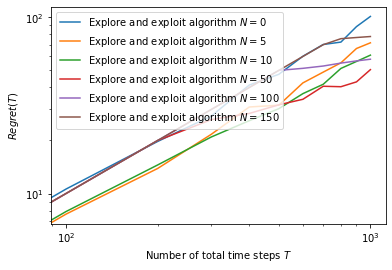

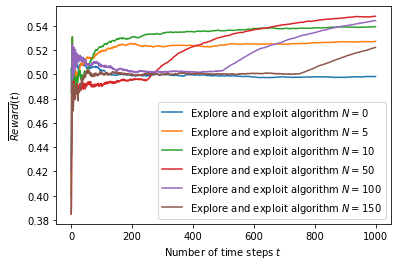

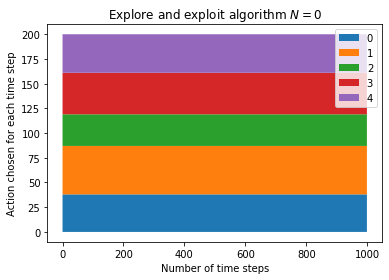

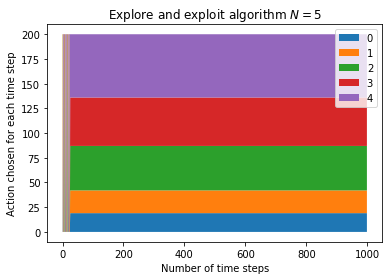

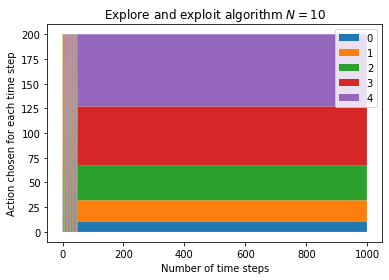

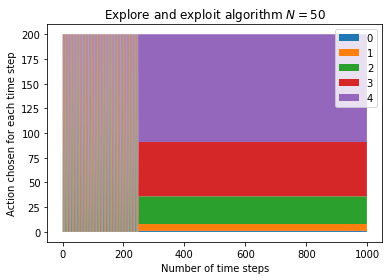

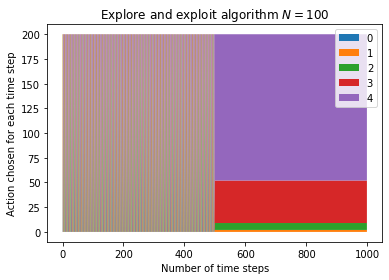

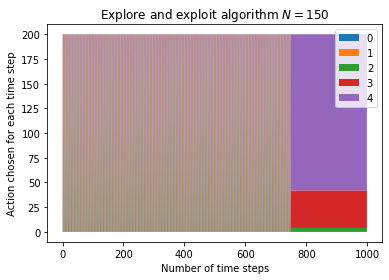

In [ ]:

MEANS = [0.0, 0.1, 0.2, 0.3, 0.4]
VARS = [3.0, 2.4, 1.8, 1.2, 0.6]
P_SUCCESSES = [0.4, 0.45, 0.5, 0.55, 0.6]

!mkdir data

def get_normal_bandit(means, vars):
    arms = [NormalArm(mean, var) for mean, var in zip(means, vars)]
    return IndependentBandit(arms)


def get_bernoulli_bandit(ps):
    arms = [BernoulliArm(p) for p in ps]
    return IndependentBandit(arms)


def get_periodic_bandit(p_min, p_max, period, n):
    arms = [BernoulliPeriodicArm(p_min, p_max, period, period * i / n) for i in range(n)]
    return IndependentBandit(arms)


def main(args):

    bandit = get_bernoulli_bandit(P_SUCCESSES)
    if args.bandit == "normal":
        bandit = get_normal_bandit(MEANS, VARS)
    elif args.bandit == "periodic":
        bandit = get_periodic_bandit(0.3, 0.7, 100, 5)

    if args.plot != "":
        plot_from_data(args.plot)

    elif args.exp == 0:
        print("Explore-exploit algorithm")
        n_explores = [0, 5, 10, 50, 100, 150]
        run_exp_exp_on_iid(bandit, n_explores, args)

    elif args.exp == 1:
        print("Optimal explore-exploit algorithm")
        run_exp_exp_opt_on_iid(bandit, args)

    elif args.exp == 2:
        print("Epsilon-greedy algorithm")
        epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 0.0, None]
        run_epsilon_on_iid(bandit, epsilons, args)

    elif args.exp == 3:
        print("Successive elimination algorithm")
        run_succ_elim_on_iid(bandit, args)

    elif args.exp == 4:
        print("UCB1 algorithm")
        run_ucb1_on_iid(bandit, args)

    elif args.exp == 5:
        print("UCB2 algorithm")
        alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
        run_ucb2_on_iid(bandit, alphas, args)

    elif args.exp == 6:
        print("All algorithms")
        run_all_on_iid(bandit, args)


if __name__ == '__main__':
    args = parse_command()
    main(args)